# Problem Statement: HW3_SankalpSingh

## IST707: Data Analytics: HW3_NBC_KNN_SVM_RF_GBM
## Date of Submission: 11/01/2020

### In this homework assignment, we are going to use multiple machine learning algorithms, including naive Bayes classifier, K Nearest Neighbor, Support Vector Machine ( with both linear and non-linear kernel functions), Random Forest and Gradient Boosting Classifier to build a disease diagnosis model. It is a binary classification problem to predict whether or not a patient has a certain unspecified disease.

### Information about the dataset (Disease Prediction Training.csv):

• Age: in years

• Gender: male/female

• Height: in unit of cm

• Weight: in unit of kg

• Low Blood Pressure: lower bound of blood pressure measurement

• High Blood Pressure: higher bound of blood pressure measurement

• Cholesterol: three cholesteral levels

• Glucose: three glucose levels

• Smoke: 1/0 regarding if the patient smokes

• Alcohol: 1/0 regarding if the patient drinks alcohol

• Exercise: 1/0 regarding if the patient exercises regularly

• Disease: The binary target variable. Does the patient have the disease?


### Import Libraries

Importing all the required libraries that will help us perform data pre-processing, visualizations, modeling and performance evaluation.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from pandas import DataFrame, Series
import seaborn as sns
from fancyimpute import IterativeImputer
from scipy import stats
from sklearn import preprocessing
from scipy.spatial import distance_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,classification_report,recall_score,roc_curve,roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
import pickle

### Read dataset

- Here we are reading both the train and test data set. We will be performing all the data pre-processing steps on both the training and testing data set. 

- Later on, while modeling we will be splitting the training dataset into training and validation to train our model and perform hyper parameter tuning using the performance on validation set. 

- Finally, we will be using the model with best parameters to predict binary labels on the testing dataset.


In [146]:
# Reading both training and testing dataset
df=pd.read_csv('Disease Prediction Training.csv')
test_df = pd.read_csv('Disease Prediction Testing.csv')

In [147]:
# Check the shape of the train data
df.shape

(49000, 12)

In [148]:
# Check the shape of the test data
test_df.shape

(21000, 12)

In [149]:
# View first few data points of training data
df.head()

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
0,59,female,167,88.0,130,68,normal,normal,0,0,1,0
1,64,female,150,71.0,140,100,normal,normal,0,0,0,1
2,41,female,166,83.0,100,70,normal,normal,0,1,1,0
3,50,male,172,110.0,130,80,normal,normal,1,0,1,0
4,39,female,162,61.0,110,80,high,high,0,0,1,0


In [150]:
# Check the data type for each of the attributes of training data
df.dtypes

Age                      int64
Gender                  object
Height                   int64
Weight                 float64
High Blood Pressure      int64
Low Blood Pressure       int64
Cholesterol             object
Glucose                 object
Smoke                    int64
Alcohol                  int64
Exercise                 int64
Disease                  int64
dtype: object

## Data Pre-processing & Exploratory Data Analysis

#### Here, we have followed the CRISP-DM methodology  which consists of following steps in the mentioned order: Business & Data Understanding -> Data cleaning & Pre-processing -> Modeling -> Performance Evaluation 

We have addressed the following data issues here while performing the data pre-processing:

1) Check for Null values

2) Handling outliers

3) Feature Engineering

4) Data Transformations


### 1) Checking for null values in train and test set

- Here, we can see that both our train and test data does not contain any null or missing values

In [151]:
# Check total null values present for all attributes in training data
df.isnull().sum()

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
Disease                0
dtype: int64

In [152]:
# Check total null values present for all attributes in testing data
test_df.isnull().sum()

ID                     0
Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
dtype: int64

### Check for distribution of labels for the target attribute

-  We can see from the distribution plot below that our training data contains almost equal number of data points for both the binary labels in our target attribute: 'Disease' - 1(Disease) / 0(No Disease)

Text(0.5, 1.0, 'Distribution of Disease for our dataset')

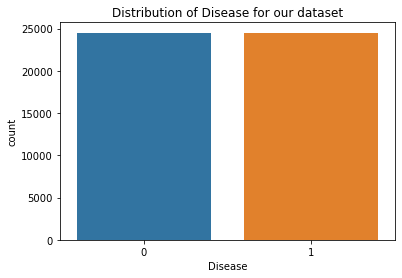

In [153]:
# Countplot to check the distribution of labels in attribute - 'Disease'
sns.countplot(x="Disease", data=df).set_title('Distribution of Disease for our dataset')

### 2) Handling outliers

- Checking for outliers in the data set and treating them accordingly is one of the major steps of pre-processing in order to achieve a higher model performance

- Below we have plotted the boxplots for our various features Vs target attribute 'Disease' to check if our numerical attributes contain any outliers

- We have used the clipping technique to deal with the outliers present in our dataset. Clipping technique involves checking for all the values present in an attribute and identifying which all values lie outside the range that we have provided for clipping

- We have clipped the outliers according to what is considered as the general lower and upper limit for each of the attributes in the medical domain. All the lower and upper limit values for each of the attributes will be clipped according to the values we have provided in the clip function

- We have clipped the values for following features - 'Height', 'Weight', 'High Blood Pressure', 'Low Blood Pressure'



#### Height

- We can see from the below boxplot that the 'Height' feature contains outliers

- The upper limit for the height variable seems to be fine

- The lower limit for the height variable is 55cm. It is highly unlikely for patients to have a height of 55cm given that the minimum Age of patients in our dataset is 29 years

- So, we have clipped the lower limit of Height variable to 100cm

Minimum height: 55
Maximum height: 207


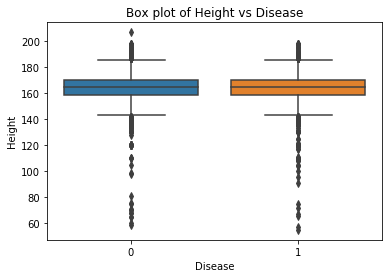

In [154]:
# Boxplot of Height attribute vs target attribute Disease
sns.boxplot(y="Height", x="Disease", data=df)
plt.title("Box plot of Height vs Disease")

# printing max and min height
print('Minimum height:', min(df['Height']))
print('Maximum height:', max(df['Height']))

In [155]:
# Clipping lower limit of height for both train and test data
df['Height'] = df["Height"].clip(lower=100)
test_df['Height'] = test_df['Height'].clip(lower=100)

#### Weight

- We can see from the below boxplot that the 'Weight' feature contains outliers
- The upper limit for the weight variable seems to be fine
- The lower limit for the weight variable is 10kg. It is highly unlikely for patients to have a weight of 10kg given that the minimum Age of patients in our dataset is 29 years
- So, we have clipped the lower limit of Weight variable to 30kg

Maximum Weight: 200.0
Minimum Weight: 10.0


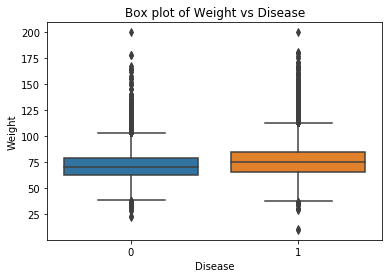

In [156]:
# Boxplot of Weight attribute vs target attribute Disease
sns.boxplot(y="Weight", x="Disease", data=df)
plt.title("Box plot of Weight vs Disease")

# printing max and min weight
print('Maximum Weight:', max(df['Weight']))
print('Minimum Weight:', min(df['Weight']))

In [157]:
# clipping the lower limit for Weight for both the train and test data
df['Weight'] = df["Weight"].clip(lower=30)
test_df['Weight'] = test_df['Weight'].clip(lower=30)

#### High Blood Pressure

- We can see from the below boxplot that the 'High Blood Pressure' feature contains outliers
- We have clipped the lower and upper limit of this variable according to the values that are generally considered as normal High BP in medical domain (60/250)

Maximum High BP: 14020
Minimum High BP: -150


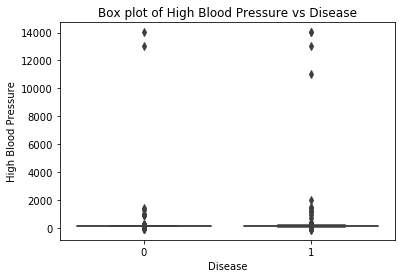

In [159]:
# Boxplot of High Blood Pressure attribute vs target attribute Disease
sns.boxplot(y="High Blood Pressure", x="Disease", data=df)
plt.title("Box plot of High Blood Pressure vs Disease")

# printing max and min High BP
print('Maximum High BP:', max(df['High Blood Pressure']))
print('Minimum High BP:', min(df['High Blood Pressure']))

In [160]:
# clipping values for High BP for train data
df['High Blood Pressure'] = df["High Blood Pressure"].clip(lower=60)
df['High Blood Pressure'] = df["High Blood Pressure"].clip(upper=250)

# clipping values for High BP for test data
test_df['High Blood Pressure'] = test_df['High Blood Pressure'].clip(lower=60)
test_df['High Blood Pressure'] = test_df['High Blood Pressure'].clip(upper=250)

#### Low Blood Pressure

- We can see from the below boxplot that the 'Low Blood Pressure' feature contains outliers
- We have clipped the lower and upper limit of this variable according to the values that are generally considered as normal Low BP in medical domain (40/160)

Maximum Low BP: 11000
Minimum Low BP: 0


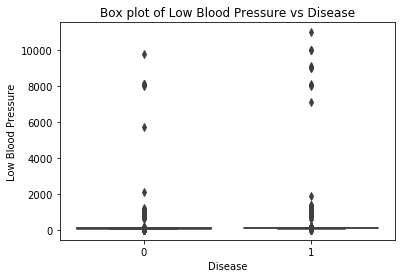

In [161]:
# Boxplot of Low Blood Pressure attribute vs target attribute Disease
sns.boxplot(y="Low Blood Pressure", x="Disease", data=df)
plt.title("Box plot of Low Blood Pressure vs Disease")

# printing max and min Low BP
print('Maximum Low BP:', max(df['Low Blood Pressure']))
print('Minimum Low BP:', min(df['Low Blood Pressure']))

In [162]:
# clipping values for Low BP for train data
df['Low Blood Pressure'] = df["Low Blood Pressure"].clip(lower=40)
df['Low Blood Pressure'] = df["Low Blood Pressure"].clip(upper=160)

# clipping values for Low BP for test data
test_df['Low Blood Pressure'] = test_df['Low Blood Pressure'].clip(lower=40)
test_df['Low Blood Pressure'] = test_df['Low Blood Pressure'].clip(upper=160)

### 3) Feature Engineering

- Feature engineering is an important step in the machine learning domain as it can help us generate new features based on some existing features in the dataset

- Here, we have calculated the Body Mass Index using the Weight and Height features and added this new feature to our dataset

- BMI is a person's weight in kilograms divided by the square of height in meters. BMI can be a good indicator of a person's health

-  A BMI higher than 30 indicates that the person is obese and a BMI of lower than 18.5 indicates that the person is underweight

- We think BMI will be an important feature that will help us in predicting disease

In [163]:
# adding BMI feature to the train data
df["BMI"]=df["Weight"]/((df['Height']/100)**2)

# adding BMI feature to the test data
test_df["BMI"]=test_df["Weight"]/((test_df['Height']/100)**2)

# printing max and min BMI in the dataset
print('Maximum BMI:', max(df['BMI']))
print('Minimum BMI:', min(df['BMI']))

Maximum BMI: 168.0
Minimum BMI: 9.46850145183689


### Exploratory Data Analysis

- Here, we have performed some exploratory data analysis on various features - 'Age', 'Gender', 'Cholestrol', 'Glucose' & 'Exercise'

- This will help us in understanding the distribution of these features in the dataset as well as their relationship with the target attribute - 'Disease'

#### Below is a Kernel density estimation plot for the 'Age' attribute which shows the distribution of 'Age' against the target feature 'Disease'. From the below plot, we can see that an old age patient is at a higher risk of having the disease. 

Minimum Age: 29
Maximum Age: 64


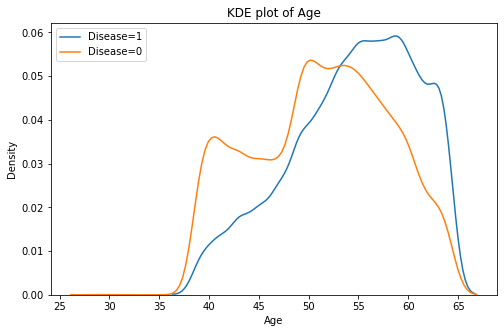

In [164]:
# KDE plot of Age Vs Disease
fig,ax=plt.subplots(1,figsize=(8,5))
ax.set_title("KDE plot of Age")
ax.set_ylabel("Density")
sns.distplot(df.Age[df.Disease==1],hist=False,label="Disease=1",ax=ax)
sns.distplot(df.Age[df.Disease==0],hist=False,label="Disease=0",ax=ax);

# printing max and min Age
print('Minimum Age:', min(df['Age']))
print('Maximum Age:', max(df['Age']))

#### Below is a distribution plot of Gender vs Disease for our dataset. We can infer from the below plot that our dataset contains more datapoints for gender=female. We can also infer that according to our dataset, males are at a slightly higher risk of having the disease than females

Text(0.5, 1.0, 'Distribution of Gender vs Disease for our dataset')

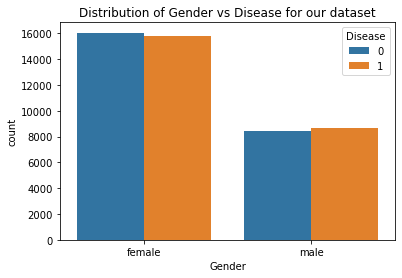

In [165]:
# Distribution plot of Gender vs Disease
sns.countplot(x="Gender", hue="Disease", data=df).set_title('Distribution of Gender vs Disease for our dataset')

#### Below is a distribution plot of Cholestrol vs Disease for our dataset. We can infer from the below plot that our dataset contains more datapoints for cholestrol=normal. We can also infer that according to our dataset, person with a very high cholestrol level is at a higher risk of having the disease

Text(0.5, 1.0, 'Distribution of Cholestrol vs Disease for our dataset')

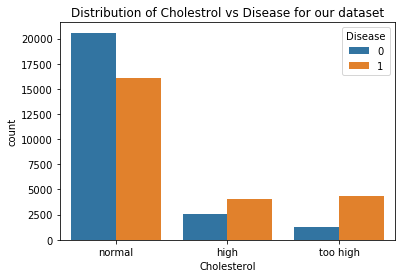

In [166]:
# Distribution plot of Cholestrol vs Disease
sns.countplot(x="Cholesterol", hue="Disease", data=df).set_title('Distribution of Cholestrol vs Disease for our dataset')

#### Below is a distribution plot of Glucose vs Disease for our dataset. We can infer from the below plot that our dataset contains more datapoints for glucose=normal. We can also infer that according to our dataset, person with a very high glucose level is at a higher risk of having the disease

Text(0.5, 1.0, 'Distribution of Glucose vs Disease for our dataset')

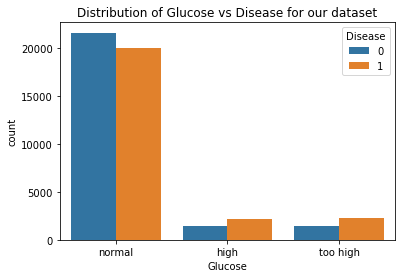

In [167]:
# Distribution plot of Glucose vs Disease
sns.countplot(x="Glucose", hue="Disease", data=df).set_title('Distribution of Glucose vs Disease for our dataset')

#### Below is a distribution plot of Exercise vs Disease for our dataset. We can infer from the plot below that according to our dataset, person who does regular exercise is at a lower risk of having the disease

Text(0.5, 1.0, 'Distribution of Exercise vs Disease for our dataset')

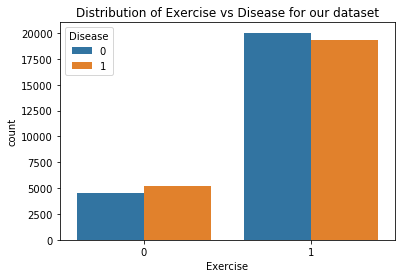

In [168]:
# Distribution plot of Exercise vs Disease
sns.countplot(x="Exercise", hue="Disease", data=df).set_title('Distribution of Exercise vs Disease for our dataset')

### 4) Data Transformations

- Here, we have performed several data transformations that will help our machine learning models in predicting the correct labels for Disease

- We have performed Binning on the Age feature and converted this attribute into 8 bins. We have seen previously from the KDE plot for Age vs Disease that the possibility of having the disease increases with age. So, we believe binning the Age feature into categories will help us in predicting the disease

-  We have also performed One-hot encoding for all the categorical features present in our dataset. After performing the One-hot encoding, we have removed one column for each of the categorical attribute. We only need to keep n-1 columns after performing One-hot encoding to remove the redundancy in our dataset.

### Binning

#### Adding a new feature 'Age_Binning' to both the train and test data

In [169]:
# creating labels for the new binned feature
ages = ['Age 25-29','Age 30-34','Age 35-39','Age 40-44','Age 45-49','Age 50-54','Age 55-59','Age 60-64']

# adding a new feature 'Age_Binning' by performing binning on 'Age' attribute for both train and test dataset
df['Age_Binning'] = pd.cut(df['Age'], bins=np.linspace(25, 65, 9), labels=ages)
test_df['Age_Binning'] = pd.cut(test_df['Age'], bins=np.linspace(25, 65, 9), labels=ages)

#### Distribution of binned age attribute against the target feature - 'Disease'. We can infer from the below plot that people in the higher age categories i.e. 50-54, 55-59, 60-64 are at the highest risk of having the disease

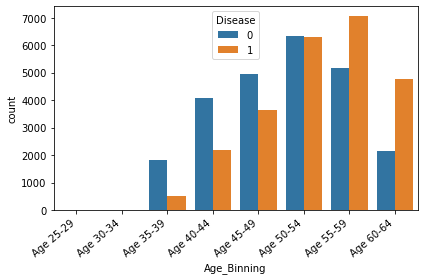

In [170]:
# plot of 'Age_Binning' vs 'Disease'
ax = sns.countplot(x="Age_Binning", hue = 'Disease', data=df)

# rotating the labels on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

### One-hot encoding

- Here, we can converted all the categorical features present in our train and test dataset into numerical features using One-hot encoding

- We have only kept n-1 columns after performing One-hot encoding as this will help in reducing the redundancy in our dataset

In [171]:
# One-hot encoding on train data
df=pd.get_dummies(df)

# One-hot encoding on test data
test_df=pd.get_dummies(test_df)

In [172]:
# Dropping 1 column each and keeping n-1 columns for all the One-hot encoded attributes on both train and test data
df.drop(["Age",'Cholesterol_too high','Glucose_too high','Age_Binning_Age 60-64'],inplace=True,axis=1)
test_df.drop(["Age",'Cholesterol_too high','Glucose_too high','Age_Binning_Age 60-64'],inplace=True,axis=1)

In [173]:
# Dropping 1 column each and keeping n-1 columns for all the One-hot encoded attributes on both train and test data
df.drop(['Gender_female'],inplace=True,axis=1)
test_df.drop(['Gender_female'],inplace=True,axis=1)

## Model Building

-  Here, we have performed some pre-processing steps required for all of our machine learning models

- Firstly, we have performed a train-validation split on our training dataset using 70-30 as the size. This will help prevent our models from overfitting and we will also be able to perform hyper-parameter tuning on validation set

- Secondly, we have used the StandardScalar technique to scale our dataset. This is an important technique which can help us improve the perfomance of our models. We have scaled the train data, validation data and the test data as well. Scaling the dataset in an important step for models that use distance-based techniques for prediction

- Thirdly, we have created a generic AUC-ROC function which will help us generate the Area Under the Receiver Operating Characrteristic curve for all the models that can predict the probability of the target class labels

- Finally, we have removed the 'ID' column from the test dataset as it will not be helpful in performing the predictions on the test data. We have popped the 'ID' column from test data and inserted it into a new dataframe - 'final_prediction' which we will be using later on to store the final predictions on test data

## Evaluation metric - Recall
- We have used the evaluation metric as Recall for all the machine learning models that we have implemented
- Though, we could have also used Accuracy as the evaluation metric because our training dataset is balanced i.e. it contains the same amount of data points for both the target labels 0 and 1
- But we have selected the metric as Recall because our goal here is to predict whether a patient has a disease or not
- So, for our kind of classification problem, it is extremely important for our models to reduce the number of 'false-negatives'. We do not want our models to predict a patient as 'not having the disease' when that patient actually 'has the disease'

In [44]:
# Define X & y for the split
X = df.drop('Disease', axis=1)
y = df['Disease']

In [45]:
# 70-30 train-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

In [46]:
# Initializing standard scalar
scaler=StandardScaler()

In [48]:
# Scaling train data
X_train[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']]=scaler.fit_transform(X_train[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']])

/Users/sankalpsingh/Vicky/Softwares/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sankalpsingh/Vicky/Softwares/Anaconda/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [49]:
# Scaling validation data
X_test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']]=scaler.transform(X_test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']])

/Users/sankalpsingh/Vicky/Softwares/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sankalpsingh/Vicky/Softwares/Anaconda/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [50]:
# Scaling test data
test_df[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']]=scaler.transform(test_df[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']])

In [52]:
# creating a new dataframe for storing the test data predictions
final_prediction=pd.DataFrame()

In [53]:
# Popping 'ID' column from test dataframe to prediction dataframe
final_prediction["ID"]=test_df.pop("ID")

#### ROC function - generic AUC-ROC function which will help us generate the Area Under the Receiver Operating Characteristic curve for all the models that can predict the probability of the target class labels

In [43]:
# Function to plot ROC_AUC_curve

def ROC_AUC_curve(model,model_name="Model"):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(8,4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

## Naive Bayes Classifier

- We have implemented the Gaussian Naive Bayes classifier model here
- We have used a 5 folds cross validation grid search to perform the hyper-parameter tuning in order to achieve the best recall for our model
- We have used recall as scoring for the grid search
- After this, we have printed the classification report for our model on training data, validation data in order to get a sense of how well our model is performing in terms of precision, recall, f1-score and accuracy
- We have predicted the target class labels for our testing dataset by using the best fitted model
- We have also generated an AUC-ROC curve for the NBC model

In [55]:
# initializing the gaussian naive bayes model
gnb = GaussianNB()

#### Hyper-paramater tuning using GridSearch:
- var_smoothing: This is a smoothing parameter which is a portion of the largest variance of all features that is added to variances for calculation stability
- n_jobs: This is a hyper-parameter used for the Grid search. n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer


In [56]:
# Performing grid search to find the best hyper-parameters
param_grid_gnb = {
              'var_smoothing': [.001,.005,.01,0.1,0.3]
              }

In [57]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_gnb = GridSearchCV(gnb, param_grid_gnb, cv=5, scoring='recall', n_jobs=-1)

In [58]:
# Fitting NBC model
gnb_model = grid_gnb.fit(X_train, y_train)

In [139]:
# printing best hyper-parameters for model
gnb_best_params = grid_gnb.best_params_
print(gnb_best_params)

{'var_smoothing': 0.001}


In [60]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(gnb_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.73      0.68      0.70     18610
           1       0.65      0.71      0.68     15690

    accuracy                           0.69     34300
   macro avg       0.69      0.69      0.69     34300
weighted avg       0.69      0.69      0.69     34300



In [61]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(gnb_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      7911
           1       0.65      0.71      0.68      6789

    accuracy                           0.69     14700
   macro avg       0.69      0.69      0.69     14700
weighted avg       0.69      0.69      0.69     14700



In [62]:
# Predicting disease labels for test dataset
test_prediction_gnb = gnb_model.predict(test_df)

#### Generating the AUC-ROC curve for the NBC model
- The AUC-ROC score that we get from the graph that we have plotted below tells us that our model is able to distinguish between the patients, if they have a disease or not, 74.3% of the time.
- The score is above 50% which means that the model is not just randomly predicting the probability of a patient having the disease

No Skill: ROC AUC=0.500
Model: ROC AUC=0.743


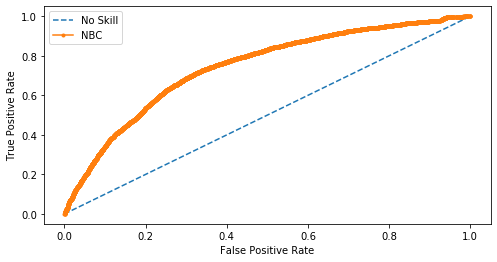

In [63]:
# printing the AUC-ROC for NBC model
ROC_AUC_curve(model=gnb_model,model_name="NBC")

## K-Nearest Neighbors
- We have implemented the K-Nearest Neighbors classifier model here
- We have used a grid search to perform the hyper parameter tuning in order to achieve the best recall for our model
- We have used recall as scoring for the grid search
- After this, we have printed the classification report for our model on training data, validation data in order to get a sense of how well our model is performing in terms of precision, recall, f1-score and accuracy
- We have predicted the target class labels for our testing dataset by using the best fitted model
- We have also generated an AUC-ROC curve for the KNN model

In [64]:
# initializing the model
knn = KNeighborsClassifier()

#### Hyper-paramater tuning using GridSearch:
- n_neighbors: This specifies the number of neighbors to be considered for classifying a point. 
- weights: If the weights are set to 'uniform' then all the k points are assigned equal weights for classification, else if the 'distance' is used, the closest points are given more weight and has more priority when classifying a point 
- algorithm: Algorithm used to compute the nearest neighbors:

             - 'ball_tree' will use BallTree
             - 'kd_tree' will use KDTree
             - 'brute' will use a brute-force search.
             - 'auto' will attempt to decide the most appropriate algorithm based on the fit method.

- p: This defines the distance function that should be used i.e. manhattan or euclidean.
- n_jobs: This is a hyper-parameter used for the Grid search. n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer

In [65]:
# Performing grid search to find the best hyper-parameters
param_grid_knn = { 'n_neighbors':[50,100,150,200],
              'weights':['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]
              }

In [66]:
# Using grid search and evaluation metric as Recall
grid_knn = GridSearchCV(knn, param_grid_knn, scoring='recall', n_jobs=-1)

In [67]:
# Fitting knn model
knn_model = grid_knn.fit(X_train, y_train)

In [68]:
# printing the best hyper-parameters
knn_best_params = knn_model.best_params_
print(knn_best_params)

{'algorithm': 'brute', 'n_neighbors': 50, 'p': 2, 'weights': 'distance'}


In [69]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(knn_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     18094
           1       0.94      0.99      0.96     16206

    accuracy                           0.96     34300
   macro avg       0.96      0.96      0.96     34300
weighted avg       0.96      0.96      0.96     34300



In [70]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(knn_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.75      0.70      0.72      7760
           1       0.69      0.73      0.71      6940

    accuracy                           0.72     14700
   macro avg       0.72      0.72      0.72     14700
weighted avg       0.72      0.72      0.72     14700



In [71]:
# Predicting disease labels for test dataset
test_prediction_knn = knn_model.predict(test_df)

#### Saving the model using pickle library

In [72]:
# Save the trained model as a pickle string. 
saved_knn_model = pickle.dumps(knn_model) 
  
# Load the pickled model 
knn_from_pickle = pickle.loads(saved_knn_model) 

#### Generating the AUC-ROC curve for the KNN model
- The AUC-ROC score that we get from the graph that we have plotted below tells us that our model is able to distinguish between the patients, if they have a disease or not, 76.2% of the time.
- The score is above 50% which means that the model is not just randomly predicting the probability of a patient having the disease

No Skill: ROC AUC=0.500
Model: ROC AUC=0.762


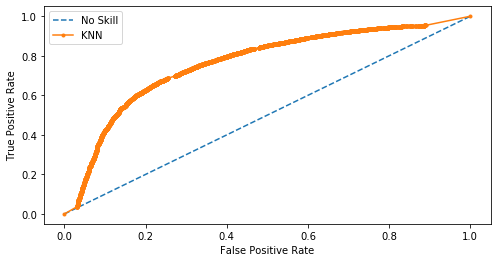

In [74]:
# ROC curve for KNN model
ROC_AUC_curve(model=knn_model,model_name="KNN")

## Linear Support Vector Machine
- We have implemented the Linear Support Vector Machine model here
- We have used a 5 folds cross validation grid search to perform the hyper parameter tuning in order to achieve the best recall for our model
- We have used recall as scoring for the grid search
- After this, we have printed the classification report for our model on training data, validation data in order to get a sense of how well our model is performing in terms of precision, recall, f1-score and accuracy
- We have predicted the target class labels for our testing dataset by using the best fitted model
- We have not generated an AUC-ROC curve as SVM model does not predict the probability of the target class labels

In [75]:
# initializing the linear SVC model
lsvm = LinearSVC(random_state=16)

#### Hyper-paramater tuning using GridSearch:
- C: This is the cost parameter. It is used for regularization and represents the penalty associated with misclassification. Higher C means lower bias but risk of overfitting. It also means higher complexity of decision boundary and higher number of support vectors. Similarly, lower C means higher bias but lower variance
- penalty: This represents the penalty as l1 and l2 regularisation parameter. The l1 and l2 both penalize the points and make the models less susceptible to outliers and improve its overall generalization.
- loss: Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.
- n_jobs: This is a hyper-parameter used for the Grid search. n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer

In [76]:
# Performing grid search to find the best hyper-parameters
param_grid_lsvm = { 'C':[.005,.01,.1,.2,.4,.8],
              'penalty':['l1', 'l2'],
              'loss': ['hinge', 'square_hinge']
              }

In [77]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_lsvm = GridSearchCV(lsvm, param_grid_lsvm, cv=5, scoring='recall', n_jobs=-1)

In [78]:
# Fitting linear svc model
lsvm_model = grid_lsvm.fit(X_train, y_train)

/Users/sankalpsingh/Vicky/Softwares/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [79]:
# printing the best hyper-parameters
lsvm_best_params = grid_lsvm.best_params_
print(lsvm_best_params)

{'C': 0.8, 'loss': 'hinge', 'penalty': 'l2'}


In [80]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(lsvm_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.82      0.69      0.75     20403
           1       0.64      0.78      0.70     13897

    accuracy                           0.73     34300
   macro avg       0.73      0.74      0.73     34300
weighted avg       0.75      0.73      0.73     34300



In [81]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(lsvm_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      8766
           1       0.63      0.79      0.70      5934

    accuracy                           0.73     14700
   macro avg       0.73      0.74      0.72     14700
weighted avg       0.75      0.73      0.73     14700



In [82]:
# Predicting disease labels for test dataset
test_prediction_lsvm = lsvm_model.predict(test_df)

## Non Linear Support Vector Machine
- We have implemented the Non Linear Support Vector Machine model here using Radial Basis Function kernel
- We have used a 5 folds cross validation grid search to perform the hyper parameter tuning in order to achieve the best recall for our model
- We have used recall as scoring for the grid search
- After this, we have printed the classification report for our model on training data, validation data in order to get a sense of how well our model is performing in terms of precision, recall, f1-score and accuracy
- We have predicted the target class labels for our testing dataset by using the best fitted model
- We have not generated an AUC-ROC curve as SVM model does not predict the probability of the target class labels

In [83]:
# initializing the rbf svm model
rbf_svm=SVC(kernel="rbf",random_state=16)

#### Hyper-paramater tuning using GridSearch:
- C: This is the cost parameter. It is used for regularization and represents the penalty associated with misclassification. Higher C means lower bias but risk of overfitting. It also means higher complexity of decision boundary 
- gamma: This is the kernel function for RBF. Higher gamma means higher risk of overfitting and lower gamma means higher bias. Gamma moves in the same direction as C
- n_jobs: This is a hyper-parameter used for the Grid search. n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer

In [84]:
# Performing grid search to find the best hyper-parameters
param_grid_rbf_svm = { 'C':[.01,.1,.4,.8,1],
              'gamma':[0.1,0.4,0.8,1],
              }

In [85]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_rbf_svm= GridSearchCV(rbf_svm, param_grid_rbf_svm, cv=5, scoring='recall', n_jobs=-1)

In [86]:
# Fitting RBF SVM model
rbf_svm_model = grid_rbf_svm.fit(X_train, y_train)

In [87]:
# printing the best hyper-parameters
rbf_svm_best_params = grid_rbf_svm.best_params_
print(rbf_svm_best_params)

{'C': 0.01, 'gamma': 1}


In [88]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(rbf_svm_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.48      0.73      0.58     11297
           1       0.82      0.61      0.70     23003

    accuracy                           0.65     34300
   macro avg       0.65      0.67      0.64     34300
weighted avg       0.71      0.65      0.66     34300



In [89]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(rbf_svm_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.47      0.71      0.57      4823
           1       0.81      0.61      0.70      9877

    accuracy                           0.64     14700
   macro avg       0.64      0.66      0.63     14700
weighted avg       0.70      0.64      0.66     14700



In [90]:
# Predicting disease labels for test dataset
test_prediction_rbf_svm = rbf_svm_model.predict(test_df)

#### Saving the model using pickle library

In [91]:
# Save the trained model as a pickle string. 
saved_rbf_svm_model = pickle.dumps(rbf_svm_model) 
  
# Load the pickled model 
rbf_svm_from_pickle = pickle.loads(saved_rbf_svm_model) 

## Random Forest
- We have implemented the Random Forest Claasifier model here 
- We have used a 5 folds cross validation grid search to perform the hyper parameter tuning in order to achieve the best recall for our model
- We have used recall as scoring for the grid search
- After this, we have printed the classification report for our model on training data, validation data in order to get a sense of how well our model is performing in terms of precision, recall, f1-score and accuracy
- We have predicted the target class labels for our testing dataset by using the best fitted model
- We have also generated an AUC-ROC curve for RF model

In [93]:
# initializing the RF model
rf=RandomForestClassifier(random_state=16,n_jobs=-1,n_estimators=100)

#### Hyper-paramater tuning using GridSearch:
- max_depth: This is the maximum depth till which the tree will keep on splitting. It ensures that the tree does not overfit the data
- max_features: The max_features is the number of features that will be used for making a single tree. For eg using "sqrt", the tree uses the square root of the number of total features in the data. Using auto is the same as making use of sqrt. The other values can be specified using the int(number of features to be used less than the total features), log, and a proportion of the features to be used
- min_samples_leaf: The minimum number of samples that should be there in leaf node. If the number is less, then the leaf node is pruned
- min_samples_split: The number of samples that should be present in the node for it to be split further
- n_estimators:This is an important tuning parameter for the Random Forest model. It is the number of trees to be used for predicting the result
- n_jobs: This is a hyper-parameter used for the Grid search. n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer

In [94]:
# Performing grid search to find the best hyper-parameters
param_grid_rf = {'max_depth': [1,25,10, 20, 100],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [10,30,50,100],
             'min_samples_split': [10,50,100,200],
             'n_estimators': [25,50,100,200]}

In [95]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_rf= GridSearchCV(rf, param_grid_rf, cv=5, scoring='recall', n_jobs=-1)

In [96]:
# Fitting RF model
rf_model = grid_rf.fit(X_train, y_train)

In [97]:
# printing the best hyper-parameters
rf_model_best_params = grid_rf.best_params_
print(rf_model_best_params)

{'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 100, 'n_estimators': 100}


In [98]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(rf_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76     18685
           1       0.70      0.77      0.74     15615

    accuracy                           0.75     34300
   macro avg       0.75      0.75      0.75     34300
weighted avg       0.75      0.75      0.75     34300



In [99]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(rf_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      8041
           1       0.68      0.76      0.72      6659

    accuracy                           0.73     14700
   macro avg       0.73      0.73      0.73     14700
weighted avg       0.73      0.73      0.73     14700



In [100]:
# Predicting disease labels for test dataset
test_prediction_rf = rf_model.predict(test_df)

#### Saving the model using pickle library

In [101]:
# Save the trained model as a pickle string. 
saved_rf_model = pickle.dumps(rf_model) 
  
# Load the pickled model 
rf_from_pickle = pickle.loads(saved_rf_model) 

#### Generating the AUC-ROC curve for the RF model
- The AUC-ROC score that we get from the graph that we have plotted below tells us that our model is able to distinguish between the patients, if they have a disease or not, 79.9% of the time.
- The score is above 50% which means that the model is not just randomly predicting the probability of a patient having the disease

No Skill: ROC AUC=0.500
Model: ROC AUC=0.799


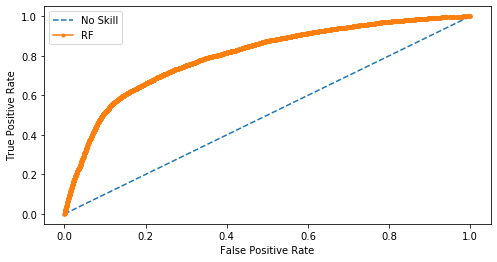

In [103]:
# ROC curve for RF model
ROC_AUC_curve(model=rf_model,model_name="RF")

#### Feature Importance Plot for Random Forest Classifier

In [104]:
# creating a new dataframe to store the features and their respective importance values
feature_imp = pd.DataFrame(rf_model.best_estimator_.feature_importances_, index=X_train.columns,
columns=['importance']).sort_values('importance', ascending=False)
feature_imp['features'] = feature_imp.index
feature_imp

,importance,features
High Blood Pressure,0.455240,High Blood Pressure
Low Blood Pressure,0.188221,Low Blood Pressure
Cholesterol_normal,0.071363,Cholesterol_normal
BMI,0.070546,BMI
Weight,0.046826,Weight
Height,0.028841,Height
Age_Binning_Age 35-39,0.028768,Age_Binning_Age 35-39
Age_Binning_Age 40-44,0.025998,Age_Binning_Age 40-44
Age_Binning_Age 45-49,0.014505,Age_Binning_Age 45-49
Cholesterol_high,0.014341,Cholesterol_high


#### Below feature importance plot shows that the top 5 features that are most helpful in predicting the disease for our dataset are:
1) High Blood Pressure

2) Low Blood Pressure

3) Cholestrol_normal

4) BMI

5) Weight

- We can see that the Body Mass Index feature that we added in our dataset as part of the feature engineering is one of the important features helpful in predicting the 'disease' target attribute

Text(0, 0.5, 'FEATURE NAMES')

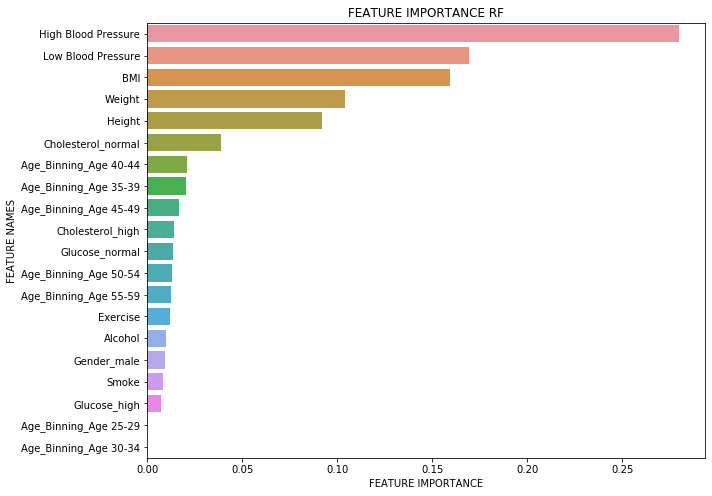

In [143]:
# Plotting Feature Importance graph
plt.figure(figsize=(10,8))

sns.barplot(x=feature_imp['importance'], y=feature_imp['features'])

plt.title('FEATURE IMPORTANCE RF')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

## Gradient Boosting Machine
- We have implemented the Gradient Boosting Machine Claasifier model here
- We have used a 5 folds cross validation grid search to perform the hyper parameter tuning in order to achieve the best recall for our model
- We have used recall as scoring for the grid search
- After this, we have printed the classification report for our model on training data, validation data in order to get a sense of how well our model is performing in terms of precision, recall, f1-score and accuracy
- We have predicted the target class labels for our testing dataset by using the best fitted model
- We have also generated an AUC-ROC curve for GBM model

In [106]:
# initializing the GBM model
gbm=GradientBoostingClassifier(random_state=16)

#### Hyper-paramater tuning using GridSearch:

- max_features: The max_features is the number of features that will be used for making a single tree. For eg using "sqrt", the tree uses the square root of the number of total features in the data. Using auto is the same as making use of sqrt. The other values can be specified using the int(number of features to be used less than the total features), log, and a proportion of the features to be used
- n_estimators:This is an important tuning parameter for the Gradient Boost model. It is the number of trees to be used for predicting the result
- subsample: The proportion of sample to be used for training individual base learner
- max_depth: This is the maximum depth till which the tree will keep on splitting. It ensures that the tree does not overfit the data
- min_samples_split: The number of samples that should be present in the node for it to be split further
- min_samples_leaf: The minimum number of samples that should be there in leaf node. If the number is less, then the leaf node is pruned
- n_jobs: This is a hyper-parameter used for the Grid search. n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer

In [107]:
# Performing grid search to find the best hyper-parameters
param_grid_gbm = {'max_features': ['auto','sqrt'],
              'n_estimators': [20,50,100,200],
              'subsample':[0.6,0.8,0.9],
              'max_depth': [1,5,20,10,50,100],
              'min_samples_split':[25,50,100,200],
              'min_samples_leaf':[10,30,50,100]}

In [108]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_gbm= GridSearchCV(gbm, param_grid_gbm, cv=5, scoring='recall', n_jobs=-1)

In [109]:
# Fitting GBM model
gbm_model = grid_gbm.fit(X_train, y_train)

In [110]:
# printing the best hyper-parameters
gbm_best_params = grid_gbm.best_params_
print(gbm_best_params)

{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 200, 'n_estimators': 100, 'subsample': 0.8}


In [111]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(gbm_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83     17845
           1       0.80      0.84      0.82     16455

    accuracy                           0.82     34300
   macro avg       0.82      0.82      0.82     34300
weighted avg       0.82      0.82      0.82     34300



In [112]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(gbm_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.74      0.71      0.73      7657
           1       0.70      0.73      0.72      7043

    accuracy                           0.72     14700
   macro avg       0.72      0.72      0.72     14700
weighted avg       0.72      0.72      0.72     14700



In [113]:
# Predicting disease labels for test dataset
test_prediction_gbm = gbm_model.predict(test_df)

#### Saving the model using pickle library

In [114]:
# Save the trained model as a pickle string. 
saved_gbm_model = pickle.dumps(gbm_model) 
  
# Load the pickled model 
gbm_from_pickle = pickle.loads(saved_gbm_model) 

#### Generating the AUC-ROC curve for the GBM model
- The AUC-ROC score that we get from the graph that we have plotted below tells us that our model is able to distinguish between the patients, if they have a disease or not, 78.8% of the time.
- The score is above 50% which means that the model is not just randomly predicting the probability of a patient having the disease

No Skill: ROC AUC=0.500
Model: ROC AUC=0.788


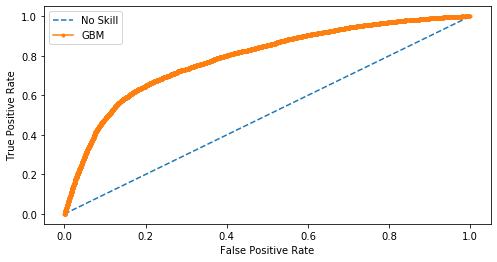

In [116]:
# printing AUC curve for GBM model
ROC_AUC_curve(model=gbm_model,model_name="GBM")

#### Feature Importance Plot for Gradient Boosting Machine Classifier

In [140]:
# creating a new dataframe to store the features and their respective importance values
feature_imp = pd.DataFrame(gbm_model.best_estimator_.feature_importances_, index=X_train.columns,
columns=['importance']).sort_values('importance', ascending=False)
feature_imp['features'] = feature_imp.index
feature_imp

,importance,features
High Blood Pressure,0.279778,High Blood Pressure
Low Blood Pressure,0.169594,Low Blood Pressure
BMI,0.159531,BMI
Weight,0.104292,Weight
Height,0.091707,Height
Cholesterol_normal,0.038821,Cholesterol_normal
Age_Binning_Age 40-44,0.020787,Age_Binning_Age 40-44
Age_Binning_Age 35-39,0.020197,Age_Binning_Age 35-39
Age_Binning_Age 45-49,0.016638,Age_Binning_Age 45-49
Cholesterol_high,0.013886,Cholesterol_high


#### Below feature importance plot shows that the top 5 features that are most helpful in predicting the disease for our dataset are:
1) High Blood Pressure

2) Low Blood Pressure

3) BMI

4) Weight

5) Height

- We can see that the Body Mass Index feature that we added in our dataset as part of the feature engineering is one of the important features helpful in predicting the 'disease' target attribute

Text(0, 0.5, 'FEATURE NAMES')

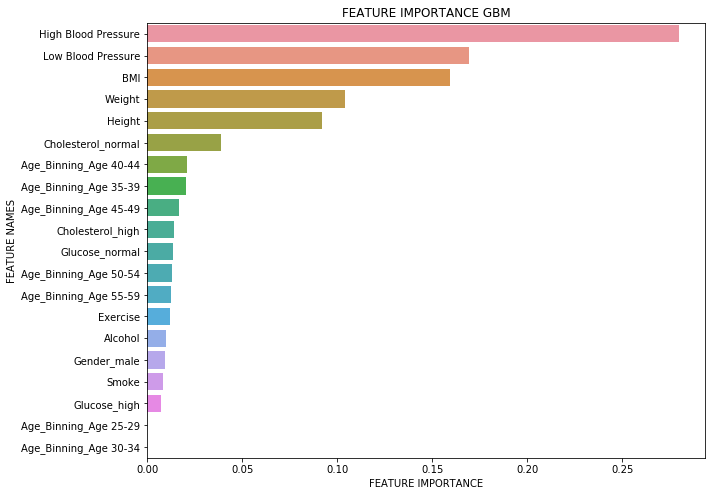

In [142]:
# Plotting Feature Importance graph
plt.figure(figsize=(10,8))

sns.barplot(x=feature_imp['importance'], y=feature_imp['features'])

plt.title('FEATURE IMPORTANCE GBM')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

## Conclusion: Prediction and Interpretation
- Below, we have summarized the results for all the 6 machine learning models that we have implemented for the Disease prediction problem

- The below table contains names of all the algorithms that we have implemented, their evaluation metric - Recall scores along with AUC and Accuracy and the best hyper-parameters for each of the model obtained through the Grid Search

- We can infer from the below table that SVM-Linear model is by far the best model to predict the disease target labels. SVM model has the highest recall score (79%). This means that a linear decision boundary could be really helpful for our dataset as we are trying to predict whether a patient has the disease or not by separting target attribute into two classes 0/1

- We can also infer that the Random Forest model has the highest Area Under the Receiver Operating Characteristic curve (79.9%). This means that RF model is also performing very well and is able to distinguish if a person has a disease or not almost 80% of the times

- We have used the evaluation metric as Recall for predicting the disease target label. We have selected Recall as the evaluation metric because it is very important for our models to correctly predict the patients with disease when they actually have the disease. We need to lower the number of 'false-negatives' in our predictions

- We can also see that all of our models have a close training and test accuracy scores. This means that our models are not prone to overfitting and they have generalized quite well on the data. One of the reasons behind this could be that training and testing datasets have a similar distribution.



In [144]:
# Creating a summary table for the model names, their recall, auc, accuracy scores and their best hyper parameters
best_models = pd.DataFrame({"Algorithm":["NBC","KNN","SVM-Linear","SVM-RBF","RF","GBM"], "Recall":[71,73,79,61,76,73],
                            "AUC":[74.3,76.2,'-','-',79.9,78.8], 'Accuracy':[69,72,73,64,73,72],
                            "Best Hyper-parameters":["var_smoothing:0.001",
                                                     "algorithm:brute,n_neighbors:50,p:2,weights:distance",
                                                     "C:0.8,loss:hinge,penalty:l2",
                                                     "C: 0.01,gamma: 1",
                                               "max_depth:100,max_features:auto,min_samples_leaf:10,min_samples_split:100,n_estimators:100",
                                               "max_depth:50,max_features:sqrt,min_samples_leaf:10,min_samples_split:200,n_estimators:100,subsample:0.8"]})

In [145]:
# Printing the best_models summary table
best_models

,Algorithm,Recall,AUC,Accuracy,Best Hyper-parameters
0,NBC,71,74.3,69,var_smoothing:0.001
1,KNN,73,76.2,72,"algorithm:brute,n_neighbors:50,p:2,weights:dis..."
2,SVM-Linear,79,-,73,"C:0.8,loss:hinge,penalty:l2"
3,SVM-RBF,61,-,64,"C: 0.01,gamma: 1"
4,RF,76,79.9,73,"max_depth:100,max_features:auto,min_samples_le..."
5,GBM,73,78.8,72,"max_depth:50,max_features:sqrt,min_samples_lea..."


## Final Predictions on Test Set 

- We have made a final dataframe containing the test set predictions for all the 6 algorithms.

- We have also converted this dataframe to a csv that contains 7 columns: 

- ID: contains the ID for each of the data points present in the test set 

- NBC: contains binary prediction labels made by the NBC algorithm for each of the data points present in the test set 

- KNN: contains binary prediction labels made by the KNN algorithm for each of the data points present in the test set 

- SVM-Linear: contains binary prediction labels made by the Linear SVM algorithm for each of the data points present in the test set 

- SVM-RBF: contains binary prediction labels made by the RBF SVM algorithm for each of the data points present in the test set 

- RF: contains binary prediction labels made by the RF algorithm for each of the data points present in the test set 

- GBM: contains binary prediction labels made by the GBM algorithm for each of the data points present in the test set 

In [117]:
# Making the final predictions on the test data set using all the 6 models and storing it in a dataframe
final_prediction_results=pd.DataFrame({"ID":final_prediction.ID,
                                       "NBC":test_prediction_gnb,
                                       "KNN":test_prediction_knn,
                                       "SVM-Linear":test_prediction_lsvm,
                                       "SVM-RBF":test_prediction_rbf_svm,
                                       "RF":test_prediction_rf,
                                       "GBM":test_prediction_gbm
                                      })

In [118]:
# Converting the final prediction results to a csv file
final_prediction_results.to_csv("final_prediction_results2.csv",index=False)